# W notebooku pokazane jest przykładowe uzycie weights and biases

In [2]:
import sys
sys.path.append('../../.') 

# BIBLIOTEKI
import wandb
import torch
import pandas as pd
import geopandas as gpd
import os
from dotenv import load_dotenv

from srai.regionalizers import H3Regionalizer, geocode_to_region_gdf
from srai.embedders import CountEmbedder

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

from src.embedders.osm_data_embedder import OSMDataEmbedder
from src.graph.create_graph import OSMEmbedderGraph
from src.baseline_models.GCN.supervised_node_classification import SupervisedNodeClassificationGNN
from src.baseline_models.GCN.GraphData import GraphData
from src.baseline_models.GCN.gcn import GCNModel


import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger


device = 'cuda' if torch.cuda.is_available() else 'mps'

import warnings
warnings.filterwarnings('ignore')

In [3]:
load_dotenv()

wandb_api_key = os.getenv("WANDB_API_KEY")

wandb.login(key=wandb_api_key)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: juliaj (gradient_pwr). Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /Users/jjaniak/.netrc


True

In [4]:
# Podział mapy Wrocławia na obszary, zliczenie danych cech w obszarze, połączenie X z Y (Y - liczba wypadów w danym obszarze)

area = geocode_to_region_gdf("Wrocław, Poland")
regionalizer = H3Regionalizer(resolution=8)
embedder = CountEmbedder()
query = {"highway": True}

embeddings = OSMDataEmbedder(area=area, embedder=embedder, regionalizer=regionalizer, query=query)
embeddings_feature_gdf = embeddings.make_embeddings()

df_accidents = pd.read_csv('../../data/embeddings.csv')

gdf = pd.merge(embeddings_feature_gdf, df_accidents, on='region_id', how='inner')

In [5]:
# Stworzenie etykiet określających poziom ryzyka na podstawie liczby wypadków + zakodowanie ich 

bins = [-1, 1, float("inf")]  # Bins: (-1, 0], (0, 2], (2, 12], (12, inf)
label_names = ['no risk', 'risk']
gdf['risk_level'] = pd.cut(gdf['rok_2023'], bins=bins, labels=label_names, right=True)

labels = gdf['risk_level']
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

gdf['risk_level'] = labels_encoded
gdf= gdf.set_index('region_id')
gdf = gdf.drop(['rok_2023'], axis=1)
gdf.head(3)

,geometry,highway_bridleway,highway_bus_stop,highway_construction,highway_corridor,highway_crossing,highway_cycleway,highway_disused:bus_stop,highway_elevator,highway_footway,...,highway_tertiary_link,highway_track,highway_traffic_mirror,highway_traffic_signals,highway_trunk,highway_trunk_link,highway_turning_circle,highway_turning_loop,highway_unclassified,risk_level
region_id,,,,,,,,,,,,,,,,,,,,,
881e2040bbfffff,"POLYGON ((17.05257 51.09230, 17.05016 51.08802...",0,3,0,0,48,42,0,0,286,...,0,13,0,9,0,0,0,0,0,1
881e2050a1fffff,"POLYGON ((16.88187 51.20572, 16.87946 51.20145...",0,0,0,0,0,0,0,0,0,...,0,6,0,0,0,0,0,0,0,0
881e20418bfffff,"POLYGON ((16.96523 51.07201, 16.96282 51.06773...",0,5,0,0,18,10,0,0,85,...,0,11,0,0,0,0,0,0,9,1


In [6]:
selected_features = ['highway_bridleway',
 'highway_bus_stop',
 'highway_elevator',
 'highway_give_way',
 'highway_motorway',
 'highway_passing_place',
 'highway_primary_link',
 'highway_secondary_link',
 'highway_stop',
 'highway_traffic_signals',
 'highway_turning_circle']

gdf_base = gdf[['geometry']+selected_features+['risk_level']]

---

## GCN model

In [7]:
# Initialize wandb
run = wandb.init(project="baseline_model", name="GCN")

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


In [8]:
# Experiment details
run.notes = "GCN for node classification"

# Log dataset information
run.log({"Dataset": "Wroclaw 2023"})

In [9]:
# Tworzenie obiektu Data z torch_geometric
G = OSMEmbedderGraph(gdf_base, "risk_level",  'shortest_path')
data = G.createGraph_Data()

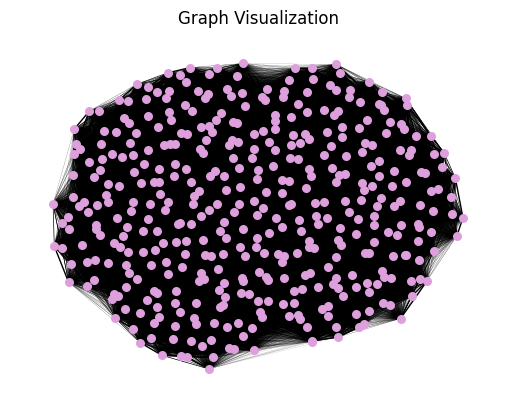

In [10]:
graph_visualization = G.graph_visualization() 
run.log({"graph_visualization": wandb.Image(graph_visualization)})


In [19]:
# Wświetlenie grafu + statystkiki 
statistics = G.show_statistics() 
wandb.log(statistics)


In [20]:
num_features = data.num_features
hidden_dim = 256
out_dim = 128
num_classes = len(data.y.unique())

max_epochs = 15
lr = 0.0001


# Log hyperparameters
config = wandb.config
config.max_epochs = max_epochs
config.lr = lr
config.hidden_dim = hidden_dim
config.out_dim = out_dim
config.num_classes = num_classes
config.num_features = num_features

In [21]:
gnn = GCNModel(in_dim=num_features, hidden_dim=hidden_dim, out_dim=out_dim)

model = SupervisedNodeClassificationGNN(gnn=gnn, emb_dim=out_dim, num_classes=num_classes, lr=lr)

In [22]:
nodes_labels = {'node': gdf_base.index.to_numpy(), 'label': data.y.cpu().numpy()}
df_to_split = pd.DataFrame(nodes_labels)

df_train, df_test = train_test_split(df_to_split, test_size=0.2, random_state=42, stratify=df_to_split['label'])
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=42, stratify=df_test['label'])

train_nodes = df_train['node']
val_nodes = df_val['node']
test_nodes = df_test['node']

train_mask = []   
val_mask = []
test_mask = []

for i in range(len(data.y)):

  if i in train_nodes:
    train_mask.append(True)
    val_mask.append(False)
    test_mask.append(False)
  elif i in val_nodes:
    train_mask.append(False)
    val_mask.append(True)
    test_mask.append(False)
  elif i in test_nodes:
    train_mask.append(False)
    val_mask.append(False)
    test_mask.append(True)

data.train_mask = torch.tensor(train_mask).cpu()
data.val_mask = torch.tensor(val_mask).cpu()
data.test_mask = torch.tensor(test_mask).cpu()

In [23]:
# Trenowanie modelu
wandb_logger = WandbLogger(log_model="all")

trainer = pl.Trainer(accelerator="cpu", max_epochs=15, logger=wandb_logger)
datamodule = GraphData([data])
trainer.fit(model=model, datamodule=datamodule)


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/trainer/setup.py:187: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/loggers/wandb.py:389: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.

  | Name                 | Type       | Params
----------------------------------------------------
0 | _gnn                 | GCNModel   | 36.0 K
1 | _classification_head | Sequential | 16.8 K
2 | _loss_fn             | NLLLoss    | 0     
----------------------------------------------------
52.7 K    Trainable params
0         Non-trainable param

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/utilities/data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 2. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python

Training: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:211: You called `self.log('step', ...)` in your `training_step` but the value needs to be floating point. Converting it to torch.float32.


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Validation: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
`Trainer.fit` stopped: `max_epochs=15` reached.


In [27]:
model_path = "gcn_model.pt"
torch.save(model.state_dict(), model_path)

artifact = wandb.Artifact('GCN_model', type='model')
artifact.add_file(model_path)
run.log_artifact(artifact)


<Artifact GCN_model>

### Komórka ponizej pokazuje przykładowe załadowanie modelu

In [31]:
artifact = run.use_artifact('gradient_pwr/baseline_model/GCN_model:v0', type='model')
model_dir = artifact.download()
model_dir


wandb:   1 of 1 files downloaded.  


'/Users/jjaniak/Documents/studia/projekt/gradient/notebooks/test_wandb/artifacts/GCN_model:v0'

---

### Results

In [33]:
# Test the model
trainer.test(model=model, datamodule=datamodule, verbose=False)

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:211: You called `self.log('step', ...)` in your `test_step` but the value needs to be floating point. Converting it to torch.float32.


[{'step': 15.0,
  'test/auc_weighted': 0.7127192982456141,
  'test/f1_weighted': 0.39986115931968064,
  'test/precision_weighted': 0.3115197404002163,
  'test/recall_weighted': 0.5581395348837209,
  'test/accuracy_weighted': 0.5581395348837209}]

In [37]:
# Tell W&B this run is finished.
run.finish()

wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job
/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:89: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display


/Users/jjaniak/anaconda3/envs/studia_projekt/lib/python3.8/site-packages/wandb/sdk/lib/ipython.py:77: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import HTML, display  # type: ignore


Directed,▁
Edges,▁
Graph density [%],▁
Nodes,▁
Nodes class,▁
Nodes dim,▁
epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
test/accuracy_weighted,▁
test/auc_weighted,▁
test/f1_weighted,▁
test/precision_weighted,▁
